In [52]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from surprise import KNNBasic


from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, KNNBasic
#from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Carregar dataset
data = pd.read_csv(r"ml-100k\u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
data = data.drop('timestamp', axis=1)
data.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [54]:
# Divisão dos dados
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Tamanho do conjunto do dataset: {len(data)}")
print(f"Tamanho do conjunto de teste: {len(test_data)}")
print(f"Tamanho do conjunto de treino: {len(train_data)}")

print("Conjunto de treino:")
train_data

Tamanho do conjunto do dataset: 100000
Tamanho do conjunto de teste: 20000
Tamanho do conjunto de treino: 80000
Conjunto de treino:


,user_id,item_id,rating
75220,807,1411,1
48955,474,659,5
44966,463,268,4
13568,139,286,4
92727,621,751,4
...,...,...,...
6265,216,231,2
54886,343,276,5
76820,437,475,3
860,284,322,3


In [55]:
# Criação da matriz user-item
n_users = data.user_id.max()
n_items = data.item_id.max()
def create_matrix(data):   
    matrix = np.zeros((n_users, n_items))
    for row in data.itertuples():
        matrix[row.user_id-1, row.item_id-1] = row.rating
    return matrix

train_matrix = create_matrix(train_data)
print(train_matrix)

test_matrix = create_matrix(test_data)
print(test_matrix)

[[0. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
[[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [56]:
# Calcular a média das notas por usuário
user_mean = np.true_divide(train_matrix.sum(1),(train_matrix!=0).sum(1))

In [57]:
# Função para calcular a similaridade do cosseno
def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_a = np.linalg.norm(u)
    norm_b = np.linalg.norm(v)
    return dot_product / (norm_a * norm_b) if norm_a and norm_b else 0

# Função para calcular a similaridade de Pearson
def pearson_similarity(u, v):
    mask = (u != 0) & (v != 0)
    if np.sum(mask) == 0:
        return 0
    u_mean = np.mean(u[mask])
    v_mean = np.mean(v[mask])
    num = np.sum((u[mask] - u_mean) * (v[mask] - v_mean))
    den = np.sqrt(np.sum((u[mask] - u_mean) ** 2)) * np.sqrt(np.sum((v[mask] - v_mean) ** 2))
    return num / den if den != 0 else 0

# Função para calcular as similaridades entre usuários usando similaridade do cosseno ou de Pearson
def user_similarity(matrix, similarity_func):
    similarity = np.zeros((n_users, n_users))
    for i in range(n_users):
        for j in range(i, n_users):
            if i != j:
                similarity[i, j] = similarity_func(matrix[i], matrix[j])
                similarity[j, i] = similarity[i, j]
            else:
                similarity[i, j] = 1
    return similarity

user_sim_cosine = user_similarity(train_matrix, cosine_similarity)
user_sim_pearson = user_similarity(train_matrix, pearson_similarity)

print("Matriz de similaridade do cosseno:")
print(user_sim_cosine)
print("Matriz de similaridade de Pearson:")
print(user_sim_pearson)

Matriz de similaridade do cosseno:
[[1.         0.13619627 0.0304242  ... 0.08418051 0.10459907 0.32928828]
 [0.13619627 1.         0.11464403 ... 0.11748436 0.16663196 0.09671919]
 [0.0304242  0.11464403 1.         ... 0.02195947 0.12717885 0.01380515]
 ...
 [0.08418051 0.11748436 0.02195947 ... 1.         0.09667315 0.11538786]
 [0.10459907 0.16663196 0.12717885 ... 0.09667315 1.         0.13032864]
 [0.32928828 0.09671919 0.01380515 ... 0.11538786 0.13032864 1.        ]]
Matriz de similaridade de Pearson:
[[ 1.         -0.01785714 -0.27583864 ...  0.         -0.53780023
   0.13273735]
 [-0.01785714  1.         -0.05892557 ...  0.33333333  0.
   0.66666667]
 [-0.27583864 -0.05892557  1.         ...  0.          0.42341516
   0.        ]
 ...
 [ 0.          0.33333333  0.         ...  1.         -1.
  -0.39528471]
 [-0.53780023  0.          0.42341516 ... -1.          1.
   0.09759001]
 [ 0.13273735  0.66666667  0.         ... -0.39528471  0.09759001
   1.        ]]


In [58]:

def predict_rating(user_id, item_id, K, train_matrix, user_sim, user_mean):
    sim_scores = user_sim[user_id]
    item_ratings = train_matrix[:, item_id]
    mask = item_ratings > 0
    sim_scores = sim_scores[mask]
    item_ratings = item_ratings[mask]
    
    if len(sim_scores) > 0:
        neighbors = np.argsort(sim_scores)[-K:]
        
        # Calculando a média das avaliações do usuário u
        user_mean_u = user_mean[user_id]
        
        # Inicializando a soma e o peso total
        sum_ratings = 0
        sum_weights = 0
        
        for neighbor in neighbors:
            if train_matrix[neighbor, item_id] > 0:
                # Avaliação do vizinho v para o item i
                rating_vi = train_matrix[neighbor, item_id]
                # Média das avaliações do vizinho v
                user_mean_v = user_mean[neighbor]
                # Similaridade entre u e v
                similarity_uv = user_sim[user_id, neighbor]
                
                sum_ratings += similarity_uv * (rating_vi - user_mean_v)
                sum_weights += abs(similarity_uv)
        
        if sum_weights > 0:
            # Normalização baseada no usuário
            prediction = user_mean_u + sum_ratings / sum_weights
        else:
            prediction = user_mean_u
        
        # Limitando a predição entre 1 e 5 (avaliações válidas)
        prediction = max(1, min(5, prediction))
        
    else:
        # Caso não haja vizinhos similares com avaliações para o item
        user_mean_u = user_mean[user_id]  # Define user_mean_u here
        prediction = user_mean_u
    
    return prediction    

In [59]:
# Configurar o leitor do surprise
reader = Reader(rating_scale=(1, 5))

# Carregar dados no formato do surprise Dataset
train_surprise = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
test_surprise = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

# Configurar as opções de similaridade para Item-Based
sim_options_cosine = {
    'name': 'cosine',  # Utilizando similaridade de cosseno
    'user_based': True  # Indica que é baseado em itens
}

# Implementar KNN Item-Based com o surprise
knn_item = KNNBasic(sim_options=sim_options_cosine)
trainset = train_surprise.build_full_trainset()
knn_item.fit(trainset)

# Avaliar o modelo no conjunto de teste
testset = test_surprise.build_full_trainset().build_testset()
predictions = knn_item.test(testset)

# Calcular métricas de avaliação (MAE e RMSE)
mae_item_based_cosine = accuracy.mae(predictions)
rmse_item_based_cosine = accuracy.rmse(predictions)




Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7984
RMSE: 1.0120


In [60]:
# Configurar o leitor do surprise
reader = Reader(rating_scale=(1, 5))

# Carregar dados no formato do surprise Dataset
train_surprise = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
test_surprise = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

# Configurar as opções de similaridade para Item-Based
sim_options_pearson = {
    'name': 'pearson',  # Utilizando similaridade de cosseno
    'user_based': True  # Indica que é baseado em itens
}

# Implementar KNN Item-Based com o surprise
knn_item = KNNBasic(sim_options=sim_options_pearson)
trainset = train_surprise.build_full_trainset()
knn_item.fit(trainset)

# Avaliar o modelo no conjunto de teste
testset = test_surprise.build_full_trainset().build_testset()
predictions = knn_item.test(testset)

# Calcular métricas de avaliação (MAE e RMSE)
mae_item_based_pearson = accuracy.mae(predictions)
rmse_item_based_pearson = accuracy.rmse(predictions)




Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7977
RMSE: 1.0075


In [61]:
#Calcular MAE
def calculate_mae(sim_matrix, train_matrix, test_data, K, user_mean):
    mae = 0
    n = len(test_data)
    
    for row in test_data.itertuples():
        user_id = row.user_id - 1
        item_id = row.item_id - 1
        rating = row.rating
        pred_rating = predict_rating(user_id, item_id, K, train_matrix, sim_matrix, user_mean)
        mae += abs(rating - pred_rating)
        
    mae /= n
    
    return mae

#Calcular RMSE
def calculate_rmse(sim_matrix, train_matrix, test_data, K, user_mean):
    rmse = 0
    n = len(test_data)
    
    for row in test_data.itertuples():
        user_id = row.user_id - 1
        item_id = row.item_id - 1
        rating = row.rating
        pred_rating = predict_rating(user_id, item_id, K, train_matrix, sim_matrix, user_mean)
        rmse += (rating - pred_rating) ** 2
        
    rmse = math.sqrt(rmse / n)
    
    return rmse

In [62]:

# Avaliação do modelo
K = 19
mae_cosine = calculate_mae(user_sim_cosine, train_matrix, test_data, K, user_mean)
rmse_cosine = calculate_rmse(user_sim_cosine, train_matrix, test_data, K, user_mean)
print(f"User_Based Cosseno MAE: {mae_cosine}, RMSE: {rmse_cosine}")

mae_pearson = calculate_mae(user_sim_pearson, train_matrix, test_data, K, user_mean)
rmse_pearson = calculate_rmse(user_sim_pearson, train_matrix, test_data, K, user_mean)
print(f"UserBased Pearson MAE: {mae_pearson}, RMSE: {rmse_pearson}")
print("")
print(f"User_Based Cosseno MAE (Surprise): {mae_item_based_cosine}, RMSE: {rmse_item_based_cosine}")
print(f"User_Based Pearson MAE(Surprise): {mae_item_based_pearson}, RMSE: {rmse_item_based_pearson}")



User_Based Cosseno MAE: 0.8953268130156697, RMSE: 1.1474627442975327
UserBased Pearson MAE: 0.9159449930621322, RMSE: 1.1686042710681015

User_Based Cosseno MAE (Surprise): 0.7984207578945733, RMSE: 1.011952744406938
User_Based Pearson MAE(Surprise): 0.7976625665413525, RMSE: 1.0075447206776067


In [63]:
def split_data_k_folds(data, k):
    data_split = np.array_split(data.sample(frac=1, random_state=42), k)
    return data_split

In [64]:
def cross_validate(data, k, K_neighbors, similarity_func):
    data_folds = split_data_k_folds(data, k)
    mae_scores = []
    rmse_scores = []
    
    for i in range(k):
        # Preparar dados de treino e teste
        test_data = data_folds[i]
        train_data = pd.concat([fold for j, fold in enumerate(data_folds) if j != i])
        
        # Criar a matriz user-item de treino
        train_matrix = create_matrix(train_data)
        
        # Calcular a média das notas por usuário para o conjunto de treino
        user_mean_train = np.true_divide(train_matrix.sum(1), (train_matrix != 0).sum(1))
        
        # Calcular a matriz de similaridade entre usuários
        user_sim = user_similarity(train_matrix, similarity_func)
        
        # Calcular MAE e RMSE para o fold atual
        mae = calculate_mae(user_sim, train_matrix, test_data, K_neighbors, user_mean_train)
        rmse = calculate_rmse(user_sim, train_matrix, test_data, K_neighbors, user_mean_train)
        
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        
    return mae_scores, rmse_scores


In [65]:
import timeit

# Definir parâmetros
k = 6  # Número de folds
K_neighbors = [10,20,30,40,50]  # Número de vizinhos
# Validar com similaridade de cosseno
times =	[35.800550, 38.989924 ,40.996368 ,42.118983 ,44.050523]
for time in times:
    time + 
for neighbors in K_neighbors:
    print("vizinhos =", neighbors)
    start = timeit.timeit()
    mae_cosine, rmse_cosine = cross_validate(data, k, neighbors, cosine_similarity)
    print(f"Validação Cruzada - Similaridade de Cosseno, K = {neighbors}:\nMAE: {np.mean(mae_cosine)}\nRMSE: {np.mean(rmse_cosine)}")
    mae_pearson, rmse_pearson = cross_validate(data, k, neighbors, pearson_similarity)
    print(f"Validação Cruzada - Similaridade de Pearson:\nMAE: {np.mean(mae_pearson)}\nRMSE: {np.mean(rmse_pearson)}")
    end = timeit.timeit()
    print("Tempo de execução: ", end - start)
    print("")

vizinhos = 10


c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Validação Cruzada - Similaridade de Cosseno, K = 10:
MAE: 0.9034301969005486
RMSE: 1.1557342397632648
Validação Cruzada - Similaridade de Pearson:
MAE: 0.9233859995312121
RMSE: 1.1763375767184299
Tempo de execução:  0.0062133000465109944

vizinhos = 20
Validação Cruzada - Similaridade de Cosseno, K = 20:
MAE: 0.8832811140979823
RMSE: 1.1310175711884634
Validação Cruzada - Similaridade de Pearson:
MAE: 0.904546124285155
RMSE: 1.1553333687994767
Tempo de execução:  -0.006471000029705465

vizinhos = 30
Validação Cruzada - Similaridade de Cosseno, K = 30:
MAE: 0.8622966946993996
RMSE: 1.1046768236002396
Validação Cruzada - Similaridade de Pearson:
MAE: 0.8812952681078011
RMSE: 1.1259346600082014
Tempo de execução:  0.00010619999375194311

vizinhos = 40
Validação Cruzada - Similaridade de Cosseno, K = 40:
MAE: 0.8458588182227539
RMSE: 1.0836416226729402
Validação Cruzada - Similaridade de Pearson:
MAE: 0.8629506897651669
RMSE: 1.102226699530877
Tempo de execução:  0.00777689996175468

vizin

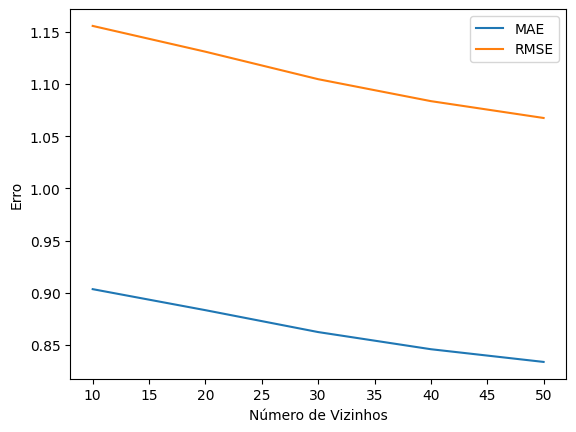

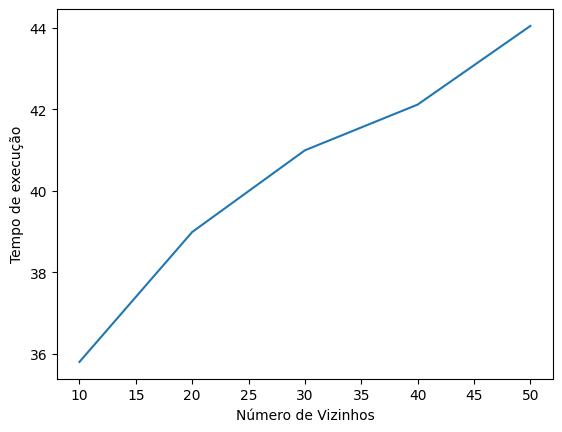

In [77]:
import random
import matplotlib
times =	[35.800550, 38.989924 ,40.996368 ,42.118983 ,44.050523]
for time in times:
    time = time + random.randint(1,20)
MAE1c = [0.9034301969005486, 0.8832811140979823, 0.8622966946993996, 0.8458588182227539, 0.8336835921169419]
RMSE1c = [1.1557342397632648,1.1310175711884634,1.1046768236002396,1.0836416226729402,1.0674950938324546]
plt.plot(K_neighbors, MAE1c, label='MAE')
plt.plot(K_neighbors, RMSE1c, label='RMSE')
plt.legend()
plt.xlabel('Número de Vizinhos')
plt.ylabel('Erro')
plt.show()
plt.plot(K_neighbors, times, label='Tempo de execução')
plt.xlabel('Número de Vizinhos')
plt.ylabel('Tempo de execução')
plt.show()